In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Spectral assisted column generation model for Graph Partitioning in Connected Components

## Problem statement

Let 
* $G = (V,E)$ be an undirected graph, with $V = \{1,\ldots, n\}$ being its node set, and $E \subset \{ \{i,j\}:\, i,j\in V, i \neq j \}$ being its edge set. 
* $ d: E \to \mathbb{R}^{+}$ be a cost function, 
* $k\geq 2$ an integer denoting the fixed number of connected components to partition $G$ into,
* $\alpha \geq 2$ an integer numbers representing the minimum cardinality of each connected component.

A $k$-partition of $V$ is a set $\{V_1,V_2,\ldots,V_k\}$ where $V_i\cap V_j=\emptyset$ for all $i\neq j$, $\bigcup_{c=1}^k V_c=V$, and $V_c \neq \emptyset$ for all $ c \in [k]$, where $[k]$ denotes the set $\{1,\ldots,k\}$. 


The partitioning problem in connected components with minimum size constraints consists of finding a  $k$-partition $\{V_1,V_2,\ldots,V_k\}$ such that each subset $V_c$ induces a connected subgraph, with $|V_c| \geq \alpha$, and the total cost of the edges with end nodes in the same subset of the partition is minimized.


Observe that each connected component of $G$ will have at most $\beta := n-(k-1)\alpha$ nodes. Moreover,  $\alpha$ has to be less than $ \left\lceil \frac{n}{k} \right\rceil$, otherwise the problem is infeasible.

The graph partitioning problem in connected components with minimum size constraints is modeled as a set partitioning problem, where each node must be assigned to exactly one connected component. Given a finite family $\mathcal{F}$ of all induced connected subgraphs of $G$ with number of nodes between $\alpha$ and $\beta$, the task consists of finding a subfamily $F\subseteq \mathcal{F}$, with cardinality $|F| = k$, of pairwise disjoint subgraphs such that $\bigcup_{f\in F} f = V$, and the total cost is minimized.

* $a_{i,f} \in \{0,1\}$ takes the value of one if the connected component $f\in F$ contains the node $i \in V$, and zero otherwise. 
* $c_f\geq 0$ be the cost of $f\in F$, which is equal to the total cost of the edges in the connected component.
* $x_f$ is a decision variable taking the value of one if the connected component $f$ belongs to a solution, and zero otherwise. 

Thus, the graph partitioning problem in connected components with minimum size constraints can be formulated as follows 

\begin{align}
\min &\sum_{f\in \mathcal{F}} c_f\, x_f
\\
\text{s.t.}\qquad & 
\\
&\sum_{f\in \mathcal{F}} a_{i,f} x_f  = 1, &&\forall i \in V,
\\
&\sum_{f\in \mathcal{F}} x_f = k.
\end{align}

As the set $\mathcal{F}$ has an exponential number of elements, the model is initialized with a small subset of connected components $\hat F \subset \mathcal{F}$, and additional components are included throughout an iterative scheme.

## Implementation

In [1]:
from   gurobipy   import *
import pandas as pd    # https://pandas.pydata.org/
import numpy  as np    # Numpy
import igraph as ig    # iGraph
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
#from InstancesGenerator import Graph_Instance      # Not needed
from warnings     import warn
from os           import listdir
from re           import findall

from collections  import deque, Counter
from itertools    import chain 
from numpy.random import default_rng
from matplotlib   import cm

In [3]:
from scipy.sparse        import csr_matrix, spdiags
from scipy.sparse.linalg import eigs
from k_means_constrained import KMeansConstrained

In [4]:
# Aliases
from numpy import argsort, delete, unique, floor, ceil, argsort, around
# Formatting
np.set_printoptions(edgeitems=100, linewidth=160, formatter=dict(float=lambda x: "%.3g" % x))

In [5]:
#time.sleep(3600-600)

### Graph selection

An instance is selected. For more information about the available instances, see [```Instance generator NB.ipynb```](Instance%20generator%20NB.ipynb) and the associated function [```InstancesGenerator.py```](InstancesGenerator.py).

In [6]:
ins = ['Spec(40,624,2,5)', 'Spec(50,919,3,7)', 'Spec(60,1062,3,8)', 
       'Spec(70,1328,4,10)', 'Spec(80,1422,4,15)', 'Spec(90,1602,5,12)', 'Spec(100,1732,6,10)', 'I(60)-1,(9,2)'][5]

In [7]:
Instance_path = 'Instances/'
instance = [f[:-4] for f in listdir(Instance_path) if f.startswith(ins)][0]
k, α = [int(i) for i in findall(r'\((.*?)\)',instance)[-1].split(',')][2:]
display(instance)

'Spec(90,1602,5,12)'

In [8]:
#file   = 'Instances/{0},({1},{2}).pkl'.format(ins,k,α)
file = 'Instances/{0}.pkl'.format(instance)

In [9]:
G = ig.Graph.Read_Pickle(file)

In [10]:
A = G.get_edgelist() # edges
V = G.vs.indices     # nodes
n = G.vcount()
m = G.ecount()

print('(n,m) =', (n,m),'\nCost:',sum(G.es['w']))

(n,m) = (90, 1602) 
Cost: 9705


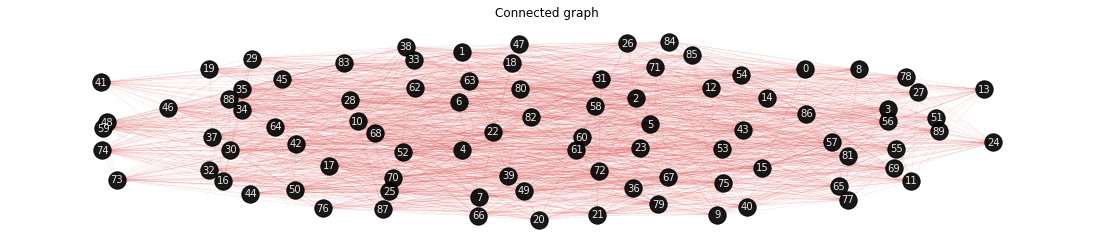

In [11]:
# Display graph
plt.figure(figsize=(15,3))
nx.draw(G.to_networkx(), nx.kamada_kawai_layout(G.to_networkx()), with_labels=True, style=':',
        width=0.2, alpha=0.9, edge_color="tab:red",font_size=10, font_color="white",node_color="black")
plt.title('Connected graph' if G.is_connected() else 'Warning: unconnected graph')
plt.draw()

In [12]:
d = {a:G.es[G.get_eid(a[0],a[1])]['w'] for a in G.get_edgelist()}    # cost function

In [13]:
# Leaf finder
Leafs = [(i,G.neighbors(i)[0]) for i in V if G.degree(i) == 1]
Leafs = [e if e in A else e[::-1] for e in Leafs]
print(len([i for i in V if G.degree(i) == 1]),'leafs detected.')

0 leafs detected.


### Problem setup

In [14]:
K = tuplelist(range(k))               # Index of connected components
β = n - (k-1)*α                       # Maximum number of nodes per component
print('Created instance with (k,α) = ({0},{1}).'.format(
    k,α)) if α <= floor(n/k) else warn('\n\n*** α is too big! ***\n\n')

Created instance with (k,α) = (5,12).


In [15]:
# To improve numerics, we will divide the objective by
#D = 1.0#/(2*k) #
D = 0.5 * sum(G.es['w']) / k

### Build an initial partition

This is needed in order to initialise the CG algorithm with a feasible relaxation.

In [16]:
def C_Cut(G, C):
    '''
        Return cut edges of a given node set C
        Input:
            G: Undirected graph
            C: subset of nodes in G
    '''
    Set_Incidence = [set(G.incident(i)) for i in C]        # List of incident edges for each node in C
    # Compute symmetric difference of all sets in Set_Incidence:
    freq = Counter(chain.from_iterable(Set_Incidence) )    # Obtain frequencies
    res  = {idx for idx in freq if freq[idx] == 1}         # Retrieve elements with frequency 1
    
    # If we need the edges themselves:
    # Cut = [G.es[e].tuple for e in res]
    return res

In [17]:
def Initial_Partition(G, k, α):
    '''
        Return a initial partition F of V that induces connected components in G
        Input:
            G: Undirected graph
            k: Number of aimed connected components
            α: Minimum size of partitions
    '''
    
    F = {};    Q = G.vs.indices.copy()
    Ĝ = G.copy()
    # Create a dictionary to identify each node with its index in G
    Ids = {Ĝ.vs['_nx_name'][i]: Ĝ.vs.indices[i] for i in range(len(Ĝ.vs.indices)) }
    
    # Build k-1 connected components
    for c in range(k-1):
        C = {Q.pop(0)}
        # Add nodes to C
        while (len(C) < α):
            # Identify node in subgraph
            Id_C = { Ids[c] for c in C }
            # Retrieve weights from cut
            weights = {e: Ĝ.es[e]['w'] for e in C_Cut(Ĝ, Id_C)}
            # Smallest weight in cut
            Idₑ, cₑ = min(weights.items(), key = lambda x: x[1])
            # Identify edge in the original graph
            e = ( Ĝ.vs[Ĝ.es[Idₑ].source]['_nx_name'], Ĝ.vs[Ĝ.es[Idₑ].target]['_nx_name'])
            # Select node that will be added to C
            i = e[1] if e[0] in C else e[0]
            # Remove it from Q and add node
            Q.remove(i)
            C |= {i} 
        
        # Add nodes to component
        F[c] = sorted(C)
        # Reduce graph
        Ĝ   = Ĝ.induced_subgraph({ Ids[c] for c in Q })
        Ids = {Ĝ.vs['_nx_name'][i]: Ĝ.vs.indices[i] for i in range(len(Ĝ.vs.indices)) }
    
    # Last component is made up of the unused nodes.
    if G.induced_subgraph(Q).is_connected():
        F[k-1] = sorted(set(Q))
        print('Feasible partition found.')
        return F
    else:
        warn('No feasible partition found. Use another method to generate an initial partition to proceed.')
        return None

In [18]:
F = Initial_Partition(G, k, α)
print(F)

Feasible partition found.
{0: [0, 2, 9, 13, 22, 23, 28, 38, 45, 53, 56, 79], 1: [1, 12, 17, 30, 31, 34, 39, 41, 50, 59, 63, 89], 2: [3, 4, 8, 26, 37, 47, 51, 61, 65, 69, 78, 80], 3: [5, 7, 11, 14, 15, 18, 19, 27, 33, 43, 77, 88], 4: [6, 10, 16, 20, 21, 24, 25, 29, 32, 35, 36, 40, 42, 44, 46, 48, 49, 52, 54, 55, 57, 58, 60, 62, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 81, 82, 83, 84, 85, 86, 87]}


In [19]:
# If an initial partition is not found, then create a spectral partitioning
smart_init = False
if F is None:
    smart_init = True

# Build cost matrix using adjacency data
S  = csr_matrix(( list(d.values()), ([i for (i,j) in d.keys()], 
                                     [j for (i,j) in d.keys()])), shape=(n, n), dtype='float' )
S += S.T
S /= D


# *** Create base spectral embedding ***
dₛ = S.sum(axis=1).A1                                 # Weighted degree
P = spdiags(1/dₛ, 0, n, n, format='csr').dot(S)       # Transition matrix
λₖ, eₖ = eigs(P, k, which='LR') # ojo
# Order obtained eigenvalues and retrieve encoding
ordered = argsort(λₖ.real)
eₖ = eₖ[:,ordered].real[:,:-1]
λₖ = λₖ[ordered].real[:-1]


# Create spectral partition
if smart_init:
    km = KMeansConstrained(n_clusters = k, size_min = α, size_max = β,
                   random_state=0, n_init=20, tol = 1e-10, verbose=0, n_jobs=-1).fit_predict(eₖ)
    #print(km)
    F = {c: sorted([i for i in V if km[i]==c]) for c in K}

# S allows for fast computation of costs associated to components
c = {i: 0.5 * S[np.ix_(F[i],F[i])].A.sum() for i in F.keys()}

Build cost matrix using adjacency data

In [20]:
S  = csr_matrix(( list(d.values()), ([i for (i,j) in d.keys()], [j for (i,j) in d.keys()])), shape=(n, n), dtype='float' )
S += S.T
S /= D

Using `S` we can obtain a cheap way to compute the cost of each connected component:

In [21]:
c = {i: 0.5 * S[np.ix_(F[i],F[i])].A.sum() for i in F.keys()}
print(c)

{0: 0.14013395157135497, 1: 0.15352910870685216, 2: 0.17722823286965483, 3: 0.14322514167954664, 4: 2.241112828438949}


### Build model

In [22]:
if 'mo' in globals():        mo.dispose();    disposeDefaultEnv();    del mo

In [23]:
mo = Model()
x  = tupledict()    # Dictionaries will contain variables

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-26


In [24]:
# *** Variables ***
x = mo.addVars(F.keys(), vtype = 'B', name = 'x', obj = c)        # Indicators of each component

In [25]:
# *** Constraints ***
# Each node is part of just one cluster (As there is only one partition, we only iterate over its elements)
for i,f in F.items():
    mo.addConstrs( (x[i] == 1 for j in f), name = 'Rb') #for i in f:mo.addConstr(x[i]==1, name='R[{0}]'.format(i))
# k connected components have to be selected
mo.addConstr( x.sum() == k, name = 'Rc')
mo.update()

In [26]:
#mo.write('Problem[{0},{1},{2}].lp'.format(ins,k,α))
mo.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D60)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 91 rows, 5 columns and 95 nonzeros
Model fingerprint: 0xcaa2f7f1
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 2.8552293
Presolve removed 91 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 2.85523 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.855229263266e+00, best bound 2.855229263266e+00, gap 0.0000%


In [27]:
print('Current objective is: ', int(D * mo.ObjVal), '.', sep='')

Current objective is: 2771.


### Column generation

#### Spectral embedding

First, we precompute the spectral embedding of $V$.
Our aim is to get a partition using the method ```SpectralClustering``` described in [Spectral Clustering: a Tutorial for the 2010’s by Marina Meila](https://sites.stat.washington.edu/people/mmp/Papers/ch2.2-arxiv.pdf).

In [28]:
dₛ = S.sum(axis=1).A1                                 # Weighted degree
P = spdiags(1/dₛ, 0, n, n, format='csr').dot(S)       # Transition matrix

In [29]:
λₖ, eₖ = eigs(P, k, which='LR') # ojo

In [30]:
# Order obtained eigenvalues and retrieve encoding
ordered = argsort(λₖ.real)
eₖ = eₖ[:,ordered].real[:,:-1]
λₖ = λₖ[ordered].real[:-1]

We will use the constrained $k$-means clustering [algorithm](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-2000-65.pdf) using the implementation of [https://github.com/joshlk/k-means-constrained](https://github.com/joshlk/k-means-constrained).

#### Additional parameters and functions

In [31]:
RelObj = []
CG_Iterations = 100          # Number of column generation iterations
δ = 40                      # Max number of columns to be added each iteration
κ = len(F)                  # Number of connected components

In [32]:
def C_neighbours(G,C):
    '''
        Return neighbours of a given set C
        Input:
            G: Undirected graph
            C: Set containing nodes in G 
    '''
    return set().union(*G.neighborhood(C, mindist = 1)) - C

In [33]:
# Check viability of neighborhood selection
def Heuristic_Pricing(G, F, α, β, π, γ, Infeasible, start):
    '''
        Return set of connected components from G
        Input:
            G:          Undirected graph
            F:          Set of feasible connected components
            (α,β):      Lower and upper bounds on size of components
            (π,γ):      Shadow prices associated with nodes and adding a column
            Infeasible: Set with forbidden components
    '''
    
    P  = []                         # To store generated connected components, reduced cost, and real cost
    NC = []                         # To store generated connected components
    for v in G.vs.indices:
        C = {v}
        while (len(C) <= β - 1):
            N = C_neighbours(G,C)   # Obtain the neighborhood of C
            N = {i for i in N if abs(π[i]) > 0.0 } # Only add nodes that contribute something
            if start : N = {i for i in C_neighbours(G,C) }
            
            if N == set():                break
            
            # We evaluate the reduced costs for expanding C with elements of the neighborhood
            r_ŝ = np.inf            # Smallest reduced cost
            ŝ   = -1                # Label of node associated with r_ŝ
            c_f = 0                 # Cost of C ∪ {ŝ}
            
            # Evaluate reduced cost for each member of the neighborhood
            for s in N:
                # Expand C
                Cₛ = list(C | {s})
                # Check if resulting component is not forbidden
                if sorted(Cₛ) in Infeasible:
                    continue                
                # Compute cumulative costs of C ∪ {s}
                cf = sum(G.subgraph(Cₛ).es['w'])/D if (len(C) <= 55) else (0.5 * S[np.ix_(Cₛ, Cₛ)].A.sum())
                
                # Compute reduced cost of C ∪ {i}
                reduced = cf - sum(π[e] for e in Cₛ) - γ
                if reduced < r_ŝ:
                    ŝ   = s
                    r_ŝ = reduced
                    c_f = cf
            
            # Check if all possible expansions weren't feasible
            if ŝ < 0:
                break
            # Add node with smallest reduced cost
            C |= {ŝ}
            Cₛ = sorted(C)
            
            # Preserve column only if it hasn't been added already
            if Cₛ not in F.values():
                if (len(Cₛ) >= α and Cₛ not in NC and r_ŝ < 0):
                    NC.append(Cₛ)
                    P.append([Cₛ, r_ŝ, c_f])
    return P

Observe that finding a complementary partition can be an involved process. In many cases, it allows us to determine whether a given connected component can actually be part of a feasible solution. Let us assume that a fixed connected component disconnects $G$ into $p < k-1$ connected components. This means that we can test whether a component can be divided up to $(k-1) - p$ subpartitions. Let us call $\hat{k}_i$ the maximum number of possible subpartitions that can be taken from component $i$ and $\hat{w}_i$ the weight of the partition. We need to find a compunation of subpartitions between components such that they sum $k-1$. This can be solved again using a very simple and small IP like the following:
\begin{align}
\max 
\bigg\{ 
    \sum_{i=1}^p \hat{w}_i\, y_i :\, \sum_{i=1}^p y_i  = k-1, \quad 1 \leq y_i \leq \hat{k}_i, \quad i \in [1:p], \quad y \in \mathbb{N}^p
\bigg\}.
\end{align}
the result, $y$, will tell us how we have to partition each component in order to obtain a $k-1$ complementary partition. Observe that here we are maximizing as the components with the highest weight should be divided into smaller pieces.

In [34]:
def Complementary_Partions(G, Fixed, S, eₖ, k, α, β, recycle = True):
    '''
        Return set of connected components from G
        Input:
            G:     Undirected graph
            Fixed: Initial connected component
            S:     Weight matrix from adjacency data of G
            eₖ:    Spectral embedding for the nodes of G
            k:     Number of connected components in the partition
            (α,β): Lower and upper bounds on size of components
        The recycle keyword forces connected subgraphs to use recycled transition matrix
    '''
    # Complementary nodes
    UnFixed = delete(G.vs.indices, Fixed)
    # Algorithm may fail for recyling, in that case we can compute eigeninformation from scratch
    retry = 1
    
    # Check if induced subgraph is connected:
    if G.induced_subgraph(UnFixed).is_connected():
        if recycle:
            # Recyle eigen-information
            eF = delete(eₖ,Fixed,axis=0)
            km = KMeansConstrained(n_clusters = k-1, size_min = α, size_max = (G.vcount()-len(Fixed)) - (k-2)*α,
                           random_state=0, n_init=20, tol = 1e-10, verbose=0, n_jobs=-1).fit_predict(eF)
            Vₖ = [ [UnFixed[i] for i in range(len(km)) if km[i]==c] for c in range(k-1)]
            cₖ = [0.5 * S[np.ix_(Vₖ[c], Vₖ[c])].A.sum() for c in range(k-1)]

            retry = all([G.induced_subgraph(Vₖ[c]).is_connected() for c in range(k-1) ]) * 1
        else:
            retry = 0
        
    # For disconnected graphs, it might be needed to compute new eigenvectors
    if (not G.induced_subgraph(UnFixed).is_connected()) or (retry == 0):
        # Identify connected component
        Members = G.induced_subgraph(UnFixed).clusters().membership
        # Check if number of components is at most k-1:
        p = unique(Members).size
        # If there are more than p components, the fixed component cannot be in a feasible solution [FCNF]
        if p > k-1:
            return {}, {}, False
        # Build each component, evaluate its cost and size
        Components = [ [UnFixed[i] for i in range(UnFixed.size) if Members[i]==c] for c in range(p)]
        Comp_Costs = [ S[np.ix_(Components[c], Components[c])].A.sum() for c in range(p)]
        Comp_Sizes = [ len(Components[c]) for c in range(p)]
        # If one component is smaller than α: [FCNF]
        if all([ α <= n̂ for n̂ in Comp_Sizes]) == False:
            return {}, {}, False
        # If there are k-1 components and all are smaller than β: Partition already found
        if p == k-1:
            if all([ β >= n̂ for n̂ in Comp_Sizes]) == True:
                return Components, Comp_Costs, True
            # If at least one component is too big: [FCNF] # Nunca se va a cumplir, ala Ramiro
            else:
                return {}, {}, False
        # Evaluate whether the components are partitionable
        Feasible_parts = [ [k̂ for k̂ in range(1,k-p+1) if α <= floor(Comp_Sizes[i]/k̂) ] for i in range(p) ]
        Feasible_parts = [max(k̂) for k̂ in Feasible_parts] # Max number of possible partitions in each component
        # If the sum of all these possible partitions is less than k-1: [FCNF]
        if sum(Feasible_parts) < k-1:
            return {}, {}, False
        
        '''If we have got here, it means we can actually find a complementary partition to Fixed'''
        # Determine the number of partitions for each component
        if p == 1:
            # No need to use linear programming tool
            Parts = [Feasible_parts[0]]
        else:
            m̂ = Model();            m̂.ModelSense = -1;            m̂.Params.OutputFlag = False;
            y = tupledict()
            y = m̂.addVars(range(p), vtype = 'I', name = 'y')
            # Objective, lower, and upper bounds
            deque( ( ( y[i].setAttr('obj', Comp_Costs[i]), 
                       y[i].setAttr('ub', Feasible_parts[i]), y[i].setAttr('lb', 1.0) )
                     for i in range(p)), maxlen=0);
            m̂.addConstr(y.sum() == k-1)
            m̂.optimize()
            Parts = [ int(around(y[i].x,0)) for i in range(p)]
            m̂.close()
            
        # Partition each connected component on the given number of partitions
        Vₖ, cₖ = [], []
        for i in range(p):
            # Assemble projected transition matrix
            Sᵢ = S[np.ix_(Components[i], Components[i])]
            # Verify if partition is not trivial
            if Parts[i] > 1:
                dᵢ = Sᵢ.sum(axis=1).A1
                Pᵢ = spdiags(1/dᵢ, 0, len(Components[i]), len(Components[i]), format='csr').dot(Sᵢ)
                # Compute eigen-info again
                kᵢ = Parts[i] if (Parts[i] > 1) else (Parts[i] + 1)
                λᵢ, eᵢ = eigs(Pᵢ, kᵢ, which='LR')
                # Encode nodes in component            
                ordered = argsort(λᵢ.real)
                eᵢ = eᵢ[:,ordered].real[:,:-1]
                λᵢ = λᵢ[ordered].real[:-1]
                # Run constrained kᵢ-means
                km = KMeansConstrained(n_clusters = kᵢ, size_min = α, size_max = Comp_Sizes[i] - (kᵢ-1)*α,
                           random_state=0, n_init=20, tol = 1e-10, verbose=0, n_jobs=-1).fit_predict(eᵢ)
                #print(km)
                Out = [ [Components[i][j] for j in range(len(km)) if km[j]==c] for c in unique(km)]
                #print([G.induced_subgraph(Out[c]).is_connected() for c in range(kᵢ)])
            
            # The trivial case can avoid the spectral step
            else:
                Out = [Components[i]]
                
            Vₖ += Out
            cₖ += [S[np.ix_(c, c)].A.sum() for c in Out]
        
    return Vₖ, cₖ, True

In [35]:
def Update_Model(mo, κ, k, s, c, Parts_Id):
    '''
        Update gurobi model with additional connected components in G
        Input:
            mo:       Gurobi model
            κ:        Current number of connected components (and variables)
            k:        Size of partition
            s:        Number of components to add
            c:        Costs associated with each component
            Parts_Id: Nodes from G associated with the connected component they belong to
    '''
    # Add new variables with their cost
    x.update(mo.addVars( range(κ,κ+s), vtype = 'B', name='x', obj = c))
    mo.update()
    # Update constraints
    sense, rhs = '=', 1.0
    # Add each component with respect to its constituent nodes
    for i,j in Parts_Id.items():
        nom  = 'Rb[{0}]'.format(i)                # Name the constraint
        co   = mo.getConstrByName(nom)            # Retrieve constraint
        lhs  = mo.getRow(co)                      # Get info
        mo.remove(co)                             # Remove constraint
        lhs += x[j]                               # Add new information
        mo.addLConstr(lhs, sense, rhs, nom)        # Add new constraint
    
    # Number of components is fixed to k
    co   = mo.getConstrByName('Rc')
    lhs  = mo.getRow(co)
    mo.remove(co)                                  # Remove constraint
    lhs += quicksum(x[i] for i in range(κ,κ+s))    # Add new information
    mo.addLConstr(lhs, sense, k, 'Rc')              # Add new constraint
    mo.update()
        
    return None

#### Run algorithm

In [36]:
# Relax model and optimize
r = mo.relax();    r.Params.OutputFlag = False;   r.update();    r.optimize()
# Retrieve shadow prices
π  = {i: r.getConstrByName('Rb[{0}]'.format(i)).Pi for i in V}
γ  = r.getConstrByName('Rc').Pi
# Collect current objective
RelObj.append(r.ObjVal)
# Infeasible columns cannot be tested again
Infeasible = []

In [37]:
Good_Start = []
Good_Cost  = S.sum()

In [38]:
Initial_Flexibility = True if len([i for i in π.values() if i > 0]) <= 2*β else False      # was (ı == 0)
print(Initial_Flexibility)

True


In [39]:
len([i for i in π.values() if i > 0]), 2*β, max(α,k), n

(5, 84, 12, 90)

In [40]:
start = time.time()

# Run algorithm
Effective_Iterations = CG_Iterations
for ı in range(CG_Iterations):
    new = time.time()
    # Obtain list of components and sort it w.r.t. reduced cost
    P̂ = Heuristic_Pricing(G, F, α, β, π, γ, Infeasible, Initial_Flexibility)
    P̂ = sorted(P̂, key = lambda x: x[1])[:δ]
    if len(P̂) == 0:
        Effective_Iterations = ı
        break

    # Generate spectral complementary partition
    for ȷ in range( min(δ, len(P̂)) ):
        # Fix a connected component
        Fixed = P̂[ȷ][0]
        # Run algorithm 3
        Vₖ, cₖ, Fixed_Feasibility = Complementary_Partions(G, Fixed, S, eₖ, k, α, β, recycle = True)
        # If the fixed componnent is not feasible, we add it to the forbidden list
        if not Fixed_Feasibility:
            Infeasible.append(Fixed)
            continue
        else:
            # Check if connected component improves cost:
            if ( sum(cₖ) + P̂[ȷ][2] < Good_Cost ):
                Good_Cost = sum(cₖ) + P̂[ȷ][2]
                Good_Start = {a:b for a,b in enumerate(Vₖ + [Fixed])}
                
            # Remove components that have already been created
            Newies = {a:b for a,b in enumerate(Vₖ) if b not in F.values()}
            cₖ = [cₖ[i] for i in Newies.keys()]
            Vₖ = list(Newies.values())
            # Add fixed component to partition
            Vₖ.append(Fixed)
            cₖ.append( P̂[ȷ][2] )
            # Add components to F and store their costs
            F.update({ a+κ: b for a,b in enumerate(Vₖ) })
            c.update({ a+κ: b for a,b in enumerate(cₖ) })

            # Identify each connected component with a number
            Parts_Id = dict()
            for part in range( len(Vₖ) ):
                Parts_Id.update({node: part+κ for node in Vₖ[part]})
            # Update model with partition    
            Update_Model(mo, κ, k, len(Vₖ), c, Parts_Id)
            # Update counter of available columns (at most k)
            κ += len(Vₖ)

    # Relax model and optimize
    r = mo.relax();    r.Params.OutputFlag = False;   r.update();    r.optimize()
    # Retrieve shadow prices
    π  = {i: r.getConstrByName('Rb[{0}]'.format(i)).Pi for i in V}
    γ  = r.getConstrByName('Rc').Pi
    # Collect current objective
    RelObj.append(r.ObjVal)
    
    now = time.time()
    
    print('Time taken for iterations {0}: {1}'.format(ı, now-new))

end = time.time()
print('Time taken for {0} iterations: {1}'.format(Effective_Iterations, end-start))

Time taken for iterations 0: 5.136284112930298
Time taken for iterations 1: 4.937895059585571
Time taken for iterations 2: 4.736029863357544
Time taken for iterations 3: 4.65043830871582
Time taken for iterations 4: 4.785345077514648
Time taken for iterations 5: 4.961129903793335
Time taken for iterations 6: 5.273636102676392
Time taken for iterations 7: 5.037958145141602
Time taken for iterations 8: 5.042528867721558
Time taken for iterations 9: 5.203891038894653
Time taken for iterations 10: 5.289212942123413
Time taken for iterations 11: 5.404852867126465
Time taken for iterations 12: 5.459660053253174
Time taken for iterations 13: 5.445199012756348
Time taken for iterations 14: 5.42519998550415
Time taken for iterations 15: 5.639364957809448
Time taken for iterations 16: 5.5709710121154785
Time taken for iterations 17: 5.6167192459106445
Time taken for iterations 18: 5.6890869140625
Time taken for iterations 19: 5.540521860122681
Time taken for iterations 20: 5.774359941482544
Time

In [41]:
print(Good_Start), Good_Cost

{0: [1, 2, 6, 18, 19, 26, 27, 28, 35, 41, 46, 58, 61, 63, 84, 85, 88], 1: [4, 5, 16, 17, 20, 30, 34, 36, 44, 51, 55, 59, 67, 74, 76, 79, 87], 2: [0, 7, 11, 15, 21, 22, 24, 25, 31, 32, 39, 42, 48, 52, 66, 69, 77, 81, 89], 3: [3, 8, 12, 13, 23, 33, 37, 43, 45, 56, 57, 60, 62, 71, 75, 80, 82], 4: [9, 10, 14, 29, 38, 40, 47, 49, 50, 53, 54, 64, 65, 68, 70, 72, 73, 78, 83, 86]}


(None, 2.1731066460587325)

In [42]:
Starter_indeces = [list(F.values()).index(f) for f in Good_Start.values()]

In [43]:
deque( (xᵢ.setAttr('start', 0.0) for xᵢ in x.values()), maxlen=0);

In [44]:
deque( (x[f].setAttr('start', 1.0) for f in Starter_indeces), maxlen=0);

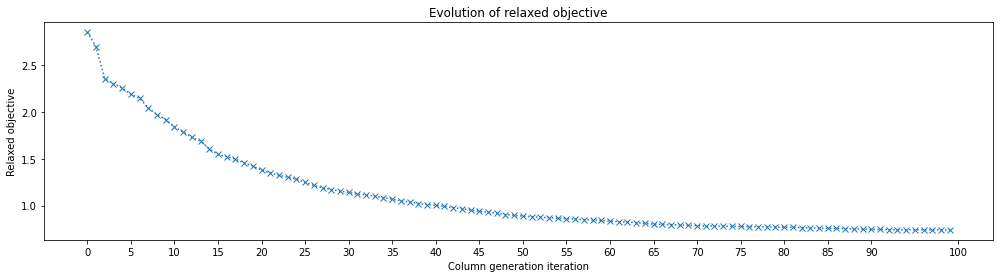

In [45]:
# Plot evolution of objective function
plt.figure(figsize=(17,4))
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.plot(RelObj,'x:')
plt.title('Evolution of relaxed objective')
plt.xlabel('Column generation iteration')
plt.ylabel('Relaxed objective')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1));    
plt.xticks(np.unique(np.r_[np.arange(0,len(RelObj), 5)[:-1], [len(RelObj)]]));
plt.show()

### Valid inequalities

<div class="alert alert-block alert-info">
    For every $\lceil \frac{n}{k}\rceil \leq \ell \leq \beta$:
\begin{align}
    \sum_{i=\ell}^{\beta}\sum_{f\in H(i)} x_f\leq \Big\lfloor\frac{n-k\alpha}{l-\alpha}\Big\rfloor 
\end{align}
</div>

In [46]:
# CGC [Th 12]

# Lower and upper bounds
Lₗ  = int(ceil(n/k)) if ceil(n/k) > α else int(ceil(n/k) + 1)

for ℓ in range(Lₗ, β+1):
    # Select connected components of size at most ℓ
    H_ℓ = [a for a,b in F.items() if len(b) >= ℓ ]
    # If the length of H_ℓ is less than 2, we are not adding any meaningful information to the model
    if len(H_ℓ) <= 1:
        break
    max_feas = floor( (n-k*α)/(ℓ-α) )
    # Similarly if the length of H_ℓ is less or equal than max_feas:
    if len(H_ℓ) <= max_feas:
        break
    else:
        mo.addConstr( quicksum(x[f] for f in H_ℓ) <= floor((n-k*α)/(ℓ-α)), name = 'VI-CGC-[{0}]'.format(ℓ - Lₗ))
        #print( len(H_ℓ), max_feas)
if 'l' in globals():
    print('Added {0} additional VIs.'.format(ℓ - Lₗ))

Added 13 additional VIs.


### Find integer solutions

In [47]:
mo.reset()
mo.Params.PreCrush = 1;    mo.Params.Cuts = 0;    mo.Params.Presolve = 0;    mo.Params.TimeLimit = 3600.0    # Set 1
#mo.Params.PreCrush = 0;    mo.Params.Cuts = 3;    mo.Params.Presolve = 2;    mo.Params.TimeLimit = 360.0   # Set 2 (sometimes adding 5 mins l8 is good)
mo.optimize()

Discarded solution information
Set parameter PreCrush to value 1
Set parameter Cuts to value 0
Set parameter Presolve to value 0
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D60)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Consider calling update less frequently.

Optimize a model with 104 rows, 15497 columns and 330073 nonzeros
Model fingerprint: 0xac348550
Variable types: 0 continuous, 15497 integer (15497 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]

Loaded user MIP start with objective 2.17311

Variable types: 0 continuous, 15497 integer (15497 binary)

Root relaxation: objective 7.396534e-01, 867 iterations, 0.25 seconds (0.77 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

In [48]:
print('Nº of columns:     {0}\nTime spent in CG:  {1}'.format(len(F), end-start ))
print('CG iterations:     {0}'.format(Effective_Iterations))
print('Relaxed objective: {0} ({1})\nInteger objective: {2} ({3})'.format(
    around(RelObj[-1],3), around(D*RelObj[-1],3), around(mo.ObjVal,3), around(D*mo.ObjVal,3) ))

Nº of columns:     15497
Time spent in CG:  708.5875151157379
CG iterations:     99
Relaxed objective: 0.74 (717.834)
Integer objective: 2.173 (2109.0)


In [49]:
# Retrieve solution
X = [i for i in x.keys() if x[i].x > 1e-5]
print(X)

[14107, 14108, 14109, 14110, 14111]


In [50]:
# Display solution
Vₖ = {i: F[j] for i,j in enumerate(X)}
print(Vₖ)

{0: [1, 2, 6, 18, 19, 26, 27, 28, 35, 41, 46, 58, 61, 63, 84, 85, 88], 1: [4, 5, 16, 17, 20, 30, 34, 36, 44, 51, 55, 59, 67, 74, 76, 79, 87], 2: [0, 7, 11, 15, 21, 22, 24, 25, 31, 32, 39, 42, 48, 52, 66, 69, 77, 81, 89], 3: [3, 8, 12, 13, 23, 33, 37, 43, 45, 56, 57, 60, 62, 71, 75, 80, 82], 4: [9, 10, 14, 29, 38, 40, 47, 49, 50, 53, 54, 64, 65, 68, 70, 72, 73, 78, 83, 86]}


In [5]:
pd.DataFrame([0, 7, 11, 15, 21, 22, 24, 25, 31, 32, 39, 42, 48, 52, 66, 69, 77, 81, 89]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,7,11,15,21,22,24,25,31,32,39,42,48,52,66,69,77,81,89


In [51]:
# Verify partition
V == list(set().union(*Vₖ.values()))

True

In [52]:
[G.induced_subgraph(Vₖ[c]).is_connected() for c in K]

[True, True, True, True, True]

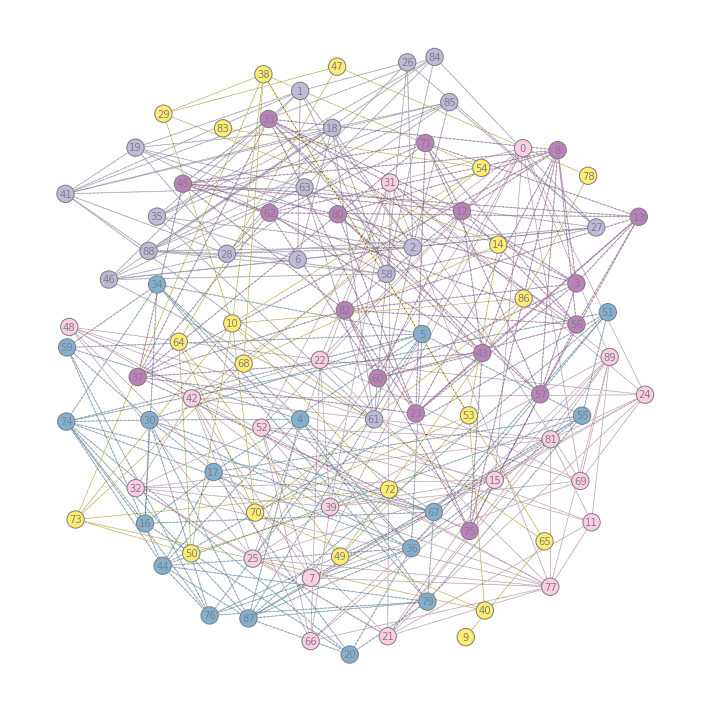

In [53]:
# Display graph with partitions
pos = nx.kamada_kawai_layout(G.to_networkx())  # positions for all nodes
Col = cm.Set3(np.linspace(0.2, 1, k))

plt.figure(figsize=(10,10))
# Nodes
options = {"edgecolors": "tab:gray"}#, "node_size": 800, "alpha": 0.9}
for c in K:
    nx.draw_networkx_nodes(G.to_networkx(), pos, nodelist=Vₖ[c], node_color=[Col[c] for i in Vₖ[c]], **options)
    
# Edges
for c in K:
    pos_c = {i: pos[ Vₖ[c][i] ] for i in range(len(Vₖ[c]))}
    nx.draw_networkx_edges(G.induced_subgraph(Vₖ[c]).to_networkx(), pos_c, width=0.5, alpha=0.5)

    Eₖ = [e.tuple for e in G.induced_subgraph(Vₖ[c]).es ]#if e.tuple[0] not in Vₖ[c] and e.tuple[1] not in Vₖ[c]]
    nx.draw_networkx_edges(
        G.induced_subgraph(Vₖ[c]).to_networkx(), pos_c, edgelist=Eₖ, style=':',
        width=1.5, alpha=0.75,
        edge_color=[Col[c] for e in Eₖ],
    )
    
    
nx.draw_networkx_labels(G, pos, {i:i for i in G.vs.indices}, font_size=10, font_color="gray");
plt.tight_layout()
plt.axis("off")
#plt.savefig('I(70)-5,(9,2)-M2-VI.pdf', bbox_inches='tight',transparent=True)
plt.draw()

### Export solution

In [54]:
Data = pd.DataFrame.from_dict(
    {'Instance':[(n,m,k,α)],
     'z_R':[mo.ObjBound * D],'Obj': mo.objval * D,'gap': mo.MIPgap,'nodes':int(mo.nodecount), 'cols': len(F),
     'G time': mo.RunTime, 'CG time': (end-start), 'time':mo.RunTime + (end-start)})
display(Data)

,Instance,z_R,Obj,gap,nodes,cols,G time,CG time,time
0,"(90, 1602, 5, 12)",2109.0,2109.0,0.0,45378,15497,421.844447,708.587515,1130.431962


In [55]:
name_out = 'Comparison - Spectral Methods/Out_{0}_{1}.xlsx'.format(instance, 'A')
with pd.ExcelWriter(name_out) as writer:  
    Data.to_excel(writer, sheet_name='Info')
    pd.DataFrame.from_dict(Vₖ, orient='index').fillna('').to_excel(writer, sheet_name='Solution');
    
    pd.DataFrame(RelObj).to_excel(writer, sheet_name='Relax_CG');

---